# Tanzanian Water Well Conditions - Trial 1

This notebook documents the exploration of Tanzanian water well data and seeks to predict the condition of each well. This is the first notebook used for data exploration. There is a second notebook with the final pre-processing and model in this repository.

## Importing Libraries and Data

#### Libraries

In [1]:
#General libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#Modeling libraries
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn import metrics
from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier

#### Data

For now, we'll only read in the training data, we can leave the test data till later.

In [2]:
train_label = pd.read_csv('train_labels.csv')
train_label.head()

,id,status_group
0,69572,functional
1,8776,functional
2,34310,functional
3,67743,non functional
4,19728,functional


In [3]:
train_values = pd.read_csv('train_values.csv')
train_values.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


Now that we know the dataframes were loaded in properly, let's take a closer look to see if there is anything we need to be aware of.

## Data Exploration and Cleaning

#### General

In [4]:
train_values.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 40 columns):
id                       59400 non-null int64
amount_tsh               59400 non-null float64
date_recorded            59400 non-null object
funder                   55765 non-null object
gps_height               59400 non-null int64
installer                55745 non-null object
longitude                59400 non-null float64
latitude                 59400 non-null float64
wpt_name                 59400 non-null object
num_private              59400 non-null int64
basin                    59400 non-null object
subvillage               59029 non-null object
region                   59400 non-null object
region_code              59400 non-null int64
district_code            59400 non-null int64
lga                      59400 non-null object
ward                     59400 non-null object
population               59400 non-null int64
public_meeting           56066 non-null object
r

The following are true about the training dataset:
- There are 40 columns (not including the labels)
    - Of those 40 columns, there are:
        - Float = 3
        - Int = 7
        - Object = 30
    - Information included in these columns:
        - Geographic information, like coordinates, region/village, and elevation
        - Water quality and water source
        - Installation data (when it was installed, who installed it)
        - Who maintains the well
        - Population that uses the well
        - and some other adminstrative details
- There are a maximum of 59,400 rows, some of which are missing data.

#### Data Types

In [5]:
cols = train_values.columns

for col in cols:
    print("Values for column: {}".format(col))
    print(train_values[col].value_counts().head())
    print('\n')

Values for column: id
2047     1
72310    1
49805    1
51852    1
62091    1
Name: id, dtype: int64


Values for column: amount_tsh
0.0       41639
500.0      3102
50.0       2472
1000.0     1488
20.0       1463
Name: amount_tsh, dtype: int64


Values for column: date_recorded
2011-03-15    572
2011-03-17    558
2013-02-03    546
2011-03-14    520
2011-03-16    513
Name: date_recorded, dtype: int64


Values for column: funder
Government Of Tanzania    9084
Danida                    3114
Hesawa                    2202
Rwssp                     1374
World Bank                1349
Name: funder, dtype: int64


Values for column: gps_height
 0     20438
-15       60
-16       55
-13       55
-20       52
Name: gps_height, dtype: int64


Values for column: installer
DWE           17402
Government     1825
RWE            1206
Commu          1060
DANIDA         1050
Name: installer, dtype: int64


Values for column: longitude
0.000000     1812
37.540901       2
33.010510       2
39.093484     

Upon further inspection of the data, it looks like there are duplicate columns, where a pair of columns are pretty much saying the same thing. I will now go through those groups of duplicative columns and determine which one to keep from each.

In [6]:
def value_check(df, cols):
    """A function used to take a closer look at duplicative columns.
    Prints out a value_check() for each column in a list.
    
    Parameters:
    df (dataframe): a dataframe with the data of interest
    cols (list): a list of columns to compare"""
    
    for col in cols:
        print("Values for column: {}".format(col))
        print(df[col].value_counts())
        print('\n')

In [7]:
# Region or Region Code
cols = ['region', 'region_code']
value_check(train_values, cols)

Values for column: region
Iringa           5294
Shinyanga        4982
Mbeya            4639
Kilimanjaro      4379
Morogoro         4006
Arusha           3350
Kagera           3316
Mwanza           3102
Kigoma           2816
Ruvuma           2640
Pwani            2635
Tanga            2547
Dodoma           2201
Singida          2093
Mara             1969
Tabora           1959
Rukwa            1808
Mtwara           1730
Manyara          1583
Lindi            1546
Dar es Salaam     805
Name: region, dtype: int64


Values for column: region_code
11    5300
17    5011
12    4639
3     4379
5     4040
18    3324
19    3047
2     3024
16    2816
10    2640
4     2513
1     2201
13    2093
14    1979
20    1969
15    1808
6     1609
21    1583
80    1238
60    1025
90     917
7      805
99     423
9      390
24     326
8      300
40       1
Name: region_code, dtype: int64




In [8]:
# Extraction_type, Extraction_type_group, or Extraction_type_class
cols = ['extraction_type', 'extraction_type_group', 'extraction_type_class']
value_check(train_values, cols)

Values for column: extraction_type
gravity                      26780
nira/tanira                   8154
other                         6430
submersible                   4764
swn 80                        3670
mono                          2865
india mark ii                 2400
afridev                       1770
ksb                           1415
other - rope pump              451
other - swn 81                 229
windmill                       117
india mark iii                  98
cemo                            90
other - play pump               85
walimi                          48
climax                          32
other - mkulima/shinyanga        2
Name: extraction_type, dtype: int64


Values for column: extraction_type_group
gravity            26780
nira/tanira         8154
other               6430
submersible         6179
swn 80              3670
mono                2865
india mark ii       2400
afridev             1770
rope pump            451
other handpump       364
other 

In [9]:
# Management or Management_group
cols = ['management', 'management_group']
value_check(train_values, cols)

Values for column: management
vwc                 40507
wug                  6515
water board          2933
wua                  2535
private operator     1971
parastatal           1768
water authority       904
other                 844
company               685
unknown               561
other - school         99
trust                  78
Name: management, dtype: int64


Values for column: management_group
user-group    52490
commercial     3638
parastatal     1768
other           943
unknown         561
Name: management_group, dtype: int64




In [10]:
# Payment or Payment_type
cols = ['payment', 'payment_type']
value_check(train_values, cols)

Values for column: payment
never pay                25348
pay per bucket            8985
pay monthly               8300
unknown                   8157
pay when scheme fails     3914
pay annually              3642
other                     1054
Name: payment, dtype: int64


Values for column: payment_type
never pay     25348
per bucket     8985
monthly        8300
unknown        8157
on failure     3914
annually       3642
other          1054
Name: payment_type, dtype: int64




In [11]:
# Water_quality or Quality_group
cols = ['water_quality', 'quality_group']
value_check(train_values, cols)

Values for column: water_quality
soft                  50818
salty                  4856
unknown                1876
milky                   804
coloured                490
salty abandoned         339
fluoride                200
fluoride abandoned       17
Name: water_quality, dtype: int64


Values for column: quality_group
good        50818
salty        5195
unknown      1876
milky         804
colored       490
fluoride      217
Name: quality_group, dtype: int64




In [12]:
# Quantity or Quantity_group
cols = ['quantity', 'quantity_group']
value_check(train_values, cols)

Values for column: quantity
enough          33186
insufficient    15129
dry              6246
seasonal         4050
unknown           789
Name: quantity, dtype: int64


Values for column: quantity_group
enough          33186
insufficient    15129
dry              6246
seasonal         4050
unknown           789
Name: quantity_group, dtype: int64




In [13]:
# Source or Source_type
cols = ['source', 'source_type']
value_check(train_values, cols)

Values for column: source
spring                  17021
shallow well            16824
machine dbh             11075
river                    9612
rainwater harvesting     2295
hand dtw                  874
lake                      765
dam                       656
other                     212
unknown                    66
Name: source, dtype: int64


Values for column: source_type
spring                  17021
shallow well            16824
borehole                11949
river/lake              10377
rainwater harvesting     2295
dam                       656
other                     278
Name: source_type, dtype: int64




In [14]:
# Waterpoint_type or Waterpoint_type_group
cols = ['waterpoint_type', 'waterpoint_type_group']
value_check(train_values, cols)

Values for column: waterpoint_type
communal standpipe             28522
hand pump                      17488
other                           6380
communal standpipe multiple     6103
improved spring                  784
cattle trough                    116
dam                                7
Name: waterpoint_type, dtype: int64


Values for column: waterpoint_type_group
communal standpipe    34625
hand pump             17488
other                  6380
improved spring         784
cattle trough           116
dam                       7
Name: waterpoint_type_group, dtype: int64




After looking through all the duplicative columns, the following will be kept:
- **'region'** = the text is easier to interpret than the values
    - **'region_code'** will be removed
- **'extraction_type_class'** and **'extraction_type_group'** = the class column is packages the well types into distinct categories, while the group column seems to include the make/model of the pump
    - **'extraction_type'** will be removed, but I may also remove **'extraction_type_group'** later on
- **'management'** = there are more categories than the **'management_group'** column
    - **'management_group'** will be removed
- **'payment_type'** = the values and value counts are the exact same as the **'payment'** column, so it is just a personal prefence to use the variables in the type column
    - **'payment'** will be removed
- **'water_quality'** = the values and value counts are almost the same as **'quality_group'**, but there are just a few more variables to split the wells into for this column
    - **'quality_group'** will be removed
- **'quantity'** = exact same as **'quantity_group'**
    - **'quantity_group'** will be removed
- **'source'** = the values and value counts are almost the same as **'source_type'**, but there are just a few more variables to split the wells into for this column
    - **'source_type'** will be removed
- **'waterpoint_type'** = the values and value counts are almost the same as **'waterpoint_type_group'**, but there are just a few more variables to split the wells into for this column
    - **'waterpoint_type_group'** will be removed

In [15]:
col_remove = ['region_code', 'extraction_type', 'management_group', 'payment', 
              'quality_group', 'quantity_group', 'source_type', 'waterpoint_type_group']

In [16]:
train_values.drop(columns = col_remove, axis=1, inplace=True)

#### Missing Values

We'll first need to figure out what to do with all the missing values.

In [17]:
train_values.isna().sum()

id                           0
amount_tsh                   0
date_recorded                0
funder                    3635
gps_height                   0
installer                 3655
longitude                    0
latitude                     0
wpt_name                     0
num_private                  0
basin                        0
subvillage                 371
region                       0
district_code                0
lga                          0
ward                         0
population                   0
public_meeting            3334
recorded_by                  0
scheme_management         3877
scheme_name              28166
permit                    3056
construction_year            0
extraction_type_group        0
extraction_type_class        0
management                   0
payment_type                 0
water_quality                0
quantity                     0
source                       0
source_class                 0
waterpoint_type              0
dtype: i

For the columns with under 4,000 rows of missing data, I'm going to remove just those rows from the dataset. For the column 'scheme_name', since just about half of the data is missing, I'm going to remove that column completely, bringing our dataset down to 39 columns.

Before I remove the respective rows and columns, I'm going to join the labels to the values dataset, that way the corresponding labels are also removed.

In [18]:
df = pd.merge(train_values, train_label, how='left', on='id')

df.drop('scheme_name', axis=1, inplace=True)
df.dropna(inplace=True)
df.reset_index(inplace=True)

#### Duplicates

Now just to check for duplicate rows, which shouldn't be an issue since our merge went off without a hitch.

In [19]:
df[df.duplicated()]

,index,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,...,extraction_type_group,extraction_type_class,management,payment_type,water_quality,quantity,source,source_class,waterpoint_type,status_group


As suspected, there are no duplicates.

#### Outliers

We've already taken a look at all the categorical columns and their values to determine which ones to keep and which to remove. Now, let's look at the numerical columns to see if there are any outliers we need to be aware of.

In [20]:
#Numerical columns
num_cols = ['amount_tsh', 'gps_height', 'num_private', 'district_code', 'population', 
           'construction_year']

In [21]:
df[num_cols].describe()

,amount_tsh,gps_height,num_private,district_code,population,construction_year
count,48288.000000,48288.000000,48288.000000,48288.000000,48288.000000,48288.000000
mean,360.417379,701.494429,0.552145,5.754618,176.683048,1342.774747
std,2828.437040,698.811196,13.291202,9.701979,472.505399,937.146464
min,0.000000,-90.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000
50%,0.000000,463.000000,0.000000,3.000000,30.000000,1987.000000
75%,50.000000,1335.000000,0.000000,5.000000,200.000000,2005.000000
max,250000.000000,2770.000000,1776.000000,80.000000,30500.000000,2013.000000


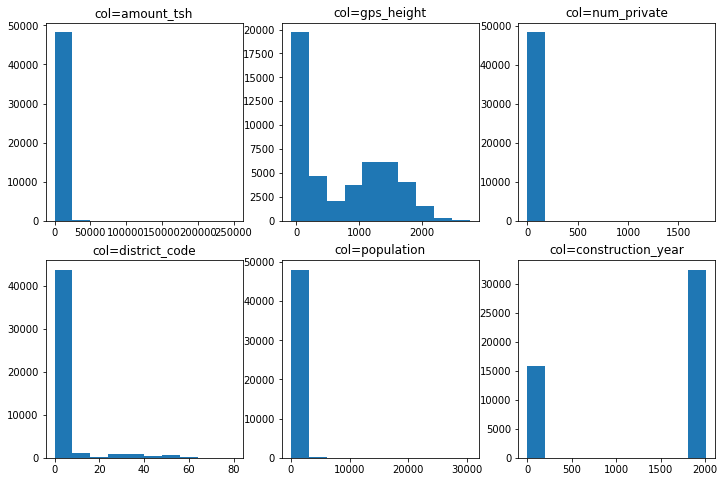

In [22]:
plt.figure(figsize=(12,8))

for k, col in enumerate(df[num_cols]):
    plt.subplot(2,3,k+1)
    plt.title("col={}".format(col))
    plt.hist(df[col])

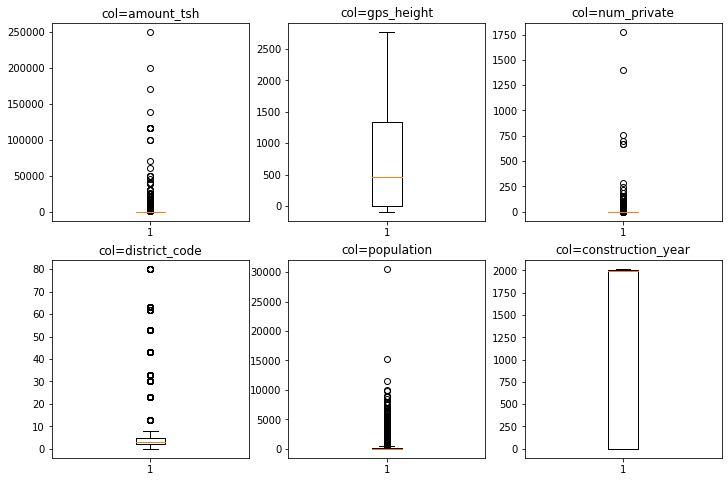

In [23]:
plt.figure(figsize=(12,8))

for k, col in enumerate(df[num_cols]):
    plt.subplot(2,3,k+1)
    plt.title("col={}".format(col))
    plt.boxplot(df[col])

Based on the summarized statistics for the numerical columns, and the histograms, we can see that there are some outliers and more missing values in the form of zeroes. 

There seems to be a large outlier in population, with a value of 30,050. There is also a huge range in values for the 'amount_tsh' (or total static head) column, from 0 up to 250,000.

It looks like a third of the wells don't have a construction year, represented by the number of zeroes in the column.

Based off of these observations, we'll need to remove some outliers.

In [24]:
#removing zeroes from construction_year
df_a = df[df.construction_year != 0]

#removing wells with more than 150 in num_private
df_b = df_a[df_a.num_private < 150]

#removing wells with more than 5,000 in population
df_c = df_b[df_b.population < 5000]

#removing wells with more than 20,000 in amount_tsh
df_d = df_c[df_c.amount_tsh < 20000]

In [25]:
df_model = df_d

#### Summary

For this first round of cleaning, the following actions were taken:
1. Duplicative columns were removed:
   - region_code, extraction_type, management_group, payment, quality_group, quantity group, source_type, waterpoint_type_group 
2. Missing values were removed:
   - The column 'scheme_name' was removed completely, as about half of the values were missing
   - The following columns only had the rows with missing values removed:
     - funder, installer, subvillage, public_meeting, scheme_management, and permit
3. Outliers were removed from the following columns:
   - construction_year: rows with '0'
   - num_private: anything above 150
   - population: anything above 5,000
   - amount_tsh: anything above 20,000

## Model Preprocessing

#### Target and Predicters

In [26]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32273 entries, 0 to 48287
Data columns (total 33 columns):
index                    32273 non-null int64
id                       32273 non-null int64
amount_tsh               32273 non-null float64
date_recorded            32273 non-null object
funder                   32273 non-null object
gps_height               32273 non-null int64
installer                32273 non-null object
longitude                32273 non-null float64
latitude                 32273 non-null float64
wpt_name                 32273 non-null object
num_private              32273 non-null int64
basin                    32273 non-null object
subvillage               32273 non-null object
region                   32273 non-null object
district_code            32273 non-null int64
lga                      32273 non-null object
ward                     32273 non-null object
population               32273 non-null int64
public_meeting           32273 non-null object
r

In [27]:
#Target variable
target_1 = df_model.status_group.map({'functional': 1, 'non functional': 0,
                                    'functional needs repair': 2})

#Predictors
pred_cols = ['amount_tsh', 'gps_height', 'region','num_private', 'population',
             'public_meeting', 'permit', 'construction_year', 'extraction_type_class',
             'management', 'payment_type', 'water_quality', 'quantity', 'source',
             'source_class', 'waterpoint_type']

predictors = df_model[pred_cols]

#### Getting Dummy Variables for Categorical Columns

In [28]:
new_preds = pd.get_dummies(predictors, drop_first=True)
new_preds.head()

,amount_tsh,gps_height,num_private,population,construction_year,region_Dar es Salaam,region_Iringa,region_Kigoma,region_Kilimanjaro,region_Lindi,...,source_spring,source_unknown,source_class_surface,source_class_unknown,waterpoint_type_communal standpipe,waterpoint_type_communal standpipe multiple,waterpoint_type_dam,waterpoint_type_hand pump,waterpoint_type_improved spring,waterpoint_type_other
0,6000.0,1390,0,109,1999,0,1,0,0,0,...,1,0,0,0,1,0,0,0,0,0
1,25.0,686,0,250,2009,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0
2,0.0,263,0,58,1986,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,20.0,0,0,1,2009,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0
6,0.0,62,0,345,2011,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


#### Multicolinearity

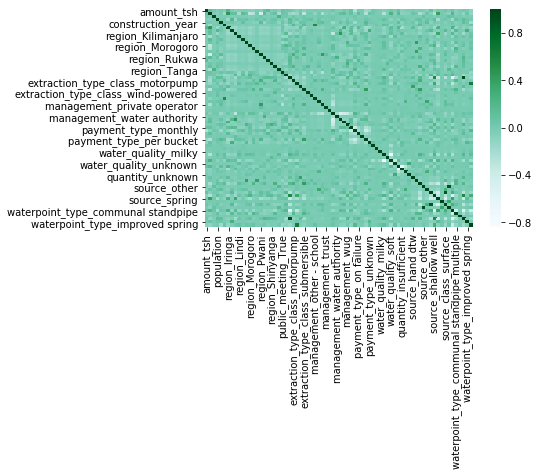

In [29]:
sns.heatmap(new_preds.corr(), cmap='BuGn')
plt.show()

In [30]:
corr_df = pd.DataFrame(new_preds.corr()[abs(new_preds.corr()) > 0.8])
corr_df.reset_index(inplace=True)
corr_df = pd.melt(corr_df, id_vars='index')
corr_df[corr_df.value < 1.0]

,index,variable,value
1773,waterpoint_type_hand pump,extraction_type_class_handpump,0.933909
3677,water_quality_soft,water_quality_salty,-0.838107
3823,water_quality_salty,water_quality_soft,-0.838107
4507,source_class_unknown,source_other,0.928013
4654,source_class_surface,source_river,0.891266
4946,source_river,source_class_surface,0.891266
5018,source_other,source_class_unknown,0.928013
5277,extraction_type_class_handpump,waterpoint_type_hand pump,0.933909


The above columns have strong relationships with each other, which is why one from each pair needs to be removed. The column with the strongest relationship with the target variable will stay in the model, while the other will be removed.

In [31]:
colin_check = pd.concat([new_preds[['waterpoint_type_hand pump', 'water_quality_soft',
                        'water_quality_salty', 'source_class_unknown',
                         'source_class_surface', 'source_river', 'source_other',
                        'extraction_type_class_handpump']], target_1], axis=1)
colin_check.corr()

,waterpoint_type_hand pump,water_quality_soft,water_quality_salty,source_class_unknown,source_class_surface,source_river,source_other,extraction_type_class_handpump,status_group
waterpoint_type_hand pump,1.000000,-0.194578,0.198836,-0.020289,-0.293061,-0.269006,-0.019719,0.933909,-0.035985
water_quality_soft,-0.194578,1.000000,-0.838107,-0.084775,0.173336,0.170766,-0.088085,-0.202039,0.139253
water_quality_salty,0.198836,-0.838107,1.000000,0.075623,-0.168168,-0.158695,0.076497,0.206656,-0.104510
source_class_unknown,-0.020289,-0.084775,0.075623,1.000000,-0.046605,-0.041537,0.928013,-0.016732,0.007553
source_class_surface,-0.293061,0.173336,-0.168168,-0.046605,1.000000,0.891266,-0.043250,-0.277008,0.097013
source_river,-0.269006,0.170766,-0.158695,-0.041537,0.891266,1.000000,-0.038547,-0.254230,0.116802
source_other,-0.019719,-0.088085,0.076497,0.928013,-0.043250,-0.038547,1.000000,-0.016286,0.007927
extraction_type_class_handpump,0.933909,-0.202039,0.206656,-0.016732,-0.277008,-0.254230,-0.016286,1.000000,-0.017350
status_group,-0.035985,0.139253,-0.104510,0.007553,0.097013,0.116802,0.007927,-0.017350,1.000000


Based on the above correlation matrix with our variables in question and our target variable, the following columns will stay in, because they had a stronger correlation:
- waterpoint_type_handpump
- water_quality_soft
- source_other
- source_river

In [32]:
rmv = ['water_quality_salty', 'source_class_unknown', 'source_class_surface',
       'extraction_type_class_handpump']

final_pred = new_preds.drop(columns=rmv, axis=1)
final_pred.head()

,amount_tsh,gps_height,num_private,population,construction_year,region_Dar es Salaam,region_Iringa,region_Kigoma,region_Kilimanjaro,region_Lindi,...,source_river,source_shallow well,source_spring,source_unknown,waterpoint_type_communal standpipe,waterpoint_type_communal standpipe multiple,waterpoint_type_dam,waterpoint_type_hand pump,waterpoint_type_improved spring,waterpoint_type_other
0,6000.0,1390,0,109,1999,0,1,0,0,0,...,0,0,1,0,1,0,0,0,0,0
1,25.0,686,0,250,2009,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,0.0,263,0,58,1986,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,20.0,0,0,1,2009,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
6,0.0,62,0,345,2011,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


#### Summary of predictors

Based on the given reasons, the following columns were removed from the list of predicter columns:
1. **id** and **wpt_name**: just unique/naming identifiers for the well
2. **latitude** and **longitude**: these will be different for almost every well, so no sense trying to use them as predicters, especially since there are more generalized location variables
3. **subvillage**, **district_code**, **lga**, **ward**: the scale of these variables is too localized, which is why **region** and **basin** were chosen instead
4. **recorded_by**: only one value for this variable
5. **extraction_type_group**: too similar to **extraction_type_class**
6. **date_recorded**
7. **funder**, **installer**, **scheme_management**: too many different values for these to variables, and they don't seem to be relevant to predicting well status

And after looking at multicolinearity within the resulting predictor dataframe, the following columns were removed:
1. **water_quality_salty**
2. **source_class_unknown**
3. **source_class_salty**
4. **extraction_type_class_handpump**

## Decision Tree Model

### Round 1 - Initial Run

In [33]:
def model_results(X_test, y_test):
    """Outputs accuracy, a confusion matrix 
    depicting F1 scores, and a classification report.
    
    Parameters:
    X_test
    y_test"""
       
    #Print results
    y_pred = clf.predict(X_test)
    
    acc = accuracy_score(y_test,y_pred) * 100
    
    cm = metrics.confusion_matrix(y_test, y_pred)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cmat = pd.DataFrame(cm)
    cmat.columns = [0,1,2]
    cmat.set_index([pd.Index([0,1,2], '')],inplace=True)
    plot = sns.heatmap(cmat,cmap="YlGnBu", annot=True)
   
    print('Accuracy Score: :{0}'.format(round(acc, 2)))
    print('\nClassification Report')
    print('----------------')
    print(metrics.classification_report(y_test, y_pred, digits=3))
    print('\nConfusion Matrix')
    print('----------------')

In [34]:
#split data into train and test
X_train, X_test, y_train, y_test = train_test_split(final_pred, target_1, random_state=22)

#Create instance of classifier and fit training data
clf = DecisionTreeClassifier(random_state=22)
clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=22, splitter='best')

Accuracy Score: :74.78

Classification Report
----------------
              precision    recall  f1-score   support

           0      0.743     0.740     0.741      2892
           1      0.803     0.803     0.803      4619
           2      0.324     0.330     0.327       558

    accuracy                          0.748      8069
   macro avg      0.623     0.624     0.624      8069
weighted avg      0.748     0.748     0.748      8069


Confusion Matrix
----------------


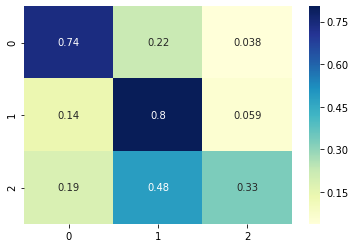

In [35]:
model_results(X_test, y_test)

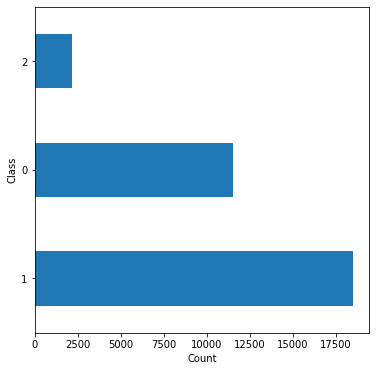

In [36]:
plt.figure(figsize=(6,6))
target_1.value_counts().plot(kind='barh')
plt.xlabel('Count')
plt.ylabel('Class')
plt.style.use('ggplot')
plt.show()

#### Interpretation of Results

Okay, so after our first round of modeling our data using a Decision Tree Classifier, we got an accuracy score of 75.02%, and after looking at the classification report, it seems that our model was able to predict both **'functional'** and **'non-functional'** wells, but had a harder time predicting our third category of wells, **'functional needs repair'**. If we look at the value counts for each of the classes in our target series, we can see that the classes are a bit unbalanced, especially the **'functional needs repair'** class.

Before tuning any hyperparameters or trying different combinations of predicter variables, we needs to balance the data.

### Round 2 - Balancing Data

In [37]:
#Joining back into one dataframe
df = pd.concat([X_train, y_train], axis=1)
df.head()

,amount_tsh,gps_height,num_private,population,construction_year,region_Dar es Salaam,region_Iringa,region_Kigoma,region_Kilimanjaro,region_Lindi,...,source_shallow well,source_spring,source_unknown,waterpoint_type_communal standpipe,waterpoint_type_communal standpipe multiple,waterpoint_type_dam,waterpoint_type_hand pump,waterpoint_type_improved spring,waterpoint_type_other,status_group
2957,0.0,323,0,350,1978,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,2
24885,0.0,1335,0,1,2011,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
37140,0.0,0,60,60,1992,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,1
46019,5000.0,1642,0,63,1972,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,1
3763,0.0,1673,0,36,2008,0,1,0,0,0,...,0,1,0,1,0,0,0,0,0,1


In [38]:
df.status_group.value_counts()

1    13922
0     8666
2     1616
Name: status_group, dtype: int64

In [39]:
#Splitting into three dataframes based on class
def upsamp(df, n_samples):
    """Upsamples train data.
    
    Parameters:
    df - train dataframe
    n_samples - integer for largest group"""
    
    df_functional = df[df.status_group == 1]
    df_nonfunc = df[df.status_group == 0]
    df_repair = df[df.status_group == 2]

    #Upsampling the dataframes with less instances
    df_nonfunc_up = resample(df_nonfunc, replace=True, n_samples=n_samples, random_state=22)
    df_repair_up = resample(df_repair, replace=True, n_samples=n_samples, random_state=22)

    #Combining back to one dataframe
    df_up = pd.concat([df_functional, df_nonfunc_up, df_repair_up])
    return df_up

In [40]:
df_up = upsamp(df, 13922)
df_up.status_group.value_counts()

2    13922
1    13922
0    13922
Name: status_group, dtype: int64

In [41]:
#New target variable and predictors
y_train = df_up.status_group
X_train = df_up.drop('status_group', axis=1)

#Create instance of classifier and fit training data
clf = DecisionTreeClassifier(random_state=22)
clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=22, splitter='best')

Accuracy Score: :74.36

Classification Report
----------------
              precision    recall  f1-score   support

           0      0.758     0.710     0.733      2892
           1      0.787     0.815     0.800      4619
           2      0.319     0.330     0.325       558

    accuracy                          0.744      8069
   macro avg      0.621     0.618     0.619      8069
weighted avg      0.744     0.744     0.743      8069


Confusion Matrix
----------------


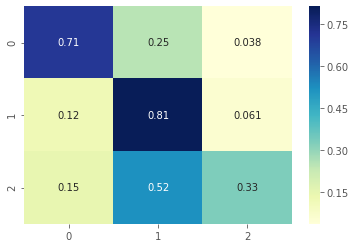

In [42]:
model_results(X_test, y_test)

#### Interpretation of Results

The upsampling of our test data didn't help, in fact, it decreased the accuracy of our model by a fraction. I think the next step is to filter out some of our predictor variables.

### Round 3 - New Predictors

In [43]:
feature_imp = pd.DataFrame({'feature': list(X_train.columns),
                            'importance': list(clf.feature_importances_)})
feature_imp.sort_values('importance', ascending=False).head()

,feature,importance
1,gps_height,0.240773
4,construction_year,0.120881
3,population,0.120742
24,extraction_type_class_other,0.047535
0,amount_tsh,0.042354


Using the `feature_importances_` attribute, we can see the top 5 important features in this decision tree model. Let's remove all other predictors except for these (we'll include all extraction types, not just other).

In [44]:
keep = ['amount_tsh', 'gps_height', 'construction_year', 'population',
        'extraction_type_class', 'status_group']

new_df = df_model[keep]
new_df.head()

,amount_tsh,gps_height,construction_year,population,extraction_type_class,status_group
0,6000.0,1390,1999,109,gravity,functional
1,25.0,686,2009,250,gravity,functional
2,0.0,263,1986,58,submersible,non functional
3,20.0,0,2009,1,submersible,functional
6,0.0,62,2011,345,submersible,functional


In [45]:
target = new_df.status_group.map({'functional': 1, 'non functional': 0,
                                    'functional needs repair': 2})

preds = new_df.drop('status_group', axis=1)

In [46]:
#Get dummies
preds = pd.get_dummies(preds, drop_first=True)
preds.head()

,amount_tsh,gps_height,construction_year,population,extraction_type_class_handpump,extraction_type_class_motorpump,extraction_type_class_other,extraction_type_class_rope pump,extraction_type_class_submersible,extraction_type_class_wind-powered
0,6000.0,1390,1999,109,0,0,0,0,0,0
1,25.0,686,2009,250,0,0,0,0,0,0
2,0.0,263,1986,58,0,0,0,0,1,0
3,20.0,0,2009,1,0,0,0,0,1,0
6,0.0,62,2011,345,0,0,0,0,1,0


In [47]:
X_train, X_test, y_train, y_test = train_test_split(preds, target, random_state=22)

df = pd.concat([X_train, y_train], axis=1)
df.status_group.value_counts()

1    13922
0     8666
2     1616
Name: status_group, dtype: int64

In [48]:
df_up = upsamp(df, n_samples=13922)

In [49]:
#New target variable and predictors
y_train = df_up.status_group
X_train = df_up.drop('status_group', axis=1)

#Create instance of classifier and fit training data
clf = DecisionTreeClassifier(random_state=22)
clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=22, splitter='best')

Accuracy Score: :66.67

Classification Report
----------------
              precision    recall  f1-score   support

           0      0.644     0.603     0.623      2892
           1      0.728     0.759     0.743      4619
           2      0.239     0.233     0.236       558

    accuracy                          0.667      8069
   macro avg      0.537     0.532     0.534      8069
weighted avg      0.664     0.667     0.665      8069


Confusion Matrix
----------------


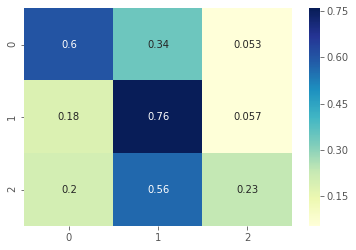

In [50]:
model_results(X_test, y_test)

That didn't seem to work either, which means we probably need to keep in more variables than we removed last time. Instead of trying this again with a decision tree, I'm going to keep all the original variables we used in the first round, and pass them through a random forest model.

## Random Forest Model

In [60]:
#creating train/test groups for random forest
X_train, X_test, y_train, y_test = train_test_split(final_pred, target_1, random_state=22)

df = pd.concat([X_train, y_train], axis=1)

In [61]:
df_up = upsamp(df, n_samples=13922)

In [62]:
#New target variable and predictors
y_train = df_up.status_group
X_train = df_up.drop('status_group', axis=1)

#Create instance of classifier and fit training data
clf = RandomForestClassifier(random_state=22)
clf.fit(X_train, y_train)

/Users/hkelderman/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=22, verbose=0,
                       warm_start=False)

Accuracy Score: :76.75

Classification Report
----------------
              precision    recall  f1-score   support

           0      0.766     0.747     0.757      2892
           1      0.810     0.831     0.821      4619
           2      0.379     0.348     0.363       558

    accuracy                          0.768      8069
   macro avg      0.652     0.642     0.647      8069
weighted avg      0.765     0.768     0.766      8069


Confusion Matrix
----------------


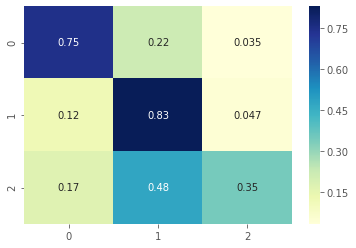

In [63]:
model_results(X_test, y_test)

#### Interpretation of Results

Using the original predictors, the random forest classifier was about two points better than the decision tree model. I know there are some hyperparameters to tweak that might increase the score a little bit, but I'm going to start fresh in a new notebook to try and get a higher base score before adjusting parameters.